#**Classification (Supervised Learning) - Using conventional ML models**

**Aim**: The objective is to study and examine the Trust pilot reviews sentiments on [TrustPilot](https://www.trustpilot.com/review/www.wexphotovideo.com) of Wex Photo Video using NLP. The data to be extracted and then existing conventional supervised models to be applied. The results to be observed and evaluated.  


In [ ]:
# Mounted data on drive so that it doesn't require upload every time google colab is loaded
from google.colab import drive
drive.mount('/content/CFA_Wex', force_remount= True)

Mounted at /content/CFA_Wex


##### **Installing Dependencies**

In [ ]:
!pip install contractions

!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


##### **Required Python Libraries**

In [ ]:
# Scraping Libraries
import os
import time
import requests
import csv
import json
import re
from bs4 import BeautifulSoup
from datetime import datetime

# Dataset Libraries
import pandas as pd
import numpy as np

# Preprocessing Libraries
import contractions
import string
import spacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter
import nltk
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE

# Visualization Libraries
import plotly.express as px
import plotly.graph_objects as go
pd.options.display.max_rows = 10
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup complete.")
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

Setup complete.


In [ ]:
# ML Libraries
import xgboost as xgb
from sklearn.svm import SVC
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from joblib import Parallel, delayed

**Store path into a global variable**

In [ ]:
path = os.getcwd() + '/CFA_Wex/MyDrive/'

**The dataset contains more neutral data collected from other resources from Kaggle.**

**References:-**

In [ ]:
combined_df = pd.read_csv(path + '/combined_data_7000.csv')

In [ ]:
combined_df.head()

,Rating,Content,Source,sentiment
0,4.0,Not sure yet. Don't have the item,PowerReviews,2
1,4.0,It would be nice if I could finish shopping be...,PowerReviews,2
2,4.0,"Seemless, so far. Need to wait for delivery to...",PowerReviews,2
3,4.0,Website slow.,PowerReviews,2
4,4.0,EASY TO USE ONLINE SYSTEM,PowerReviews,2


In [ ]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21378 entries, 0 to 21377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Rating     21378 non-null  float64
 1   Content    21378 non-null  object 
 2   Source     21378 non-null  object 
 3   sentiment  21378 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 668.2+ KB


In [ ]:
combined_df['Rating'].value_counts()

Rating
3.0    7131
4.0    3628
1.0    3607
5.0    3599
2.0    3413
Name: count, dtype: int64

In [ ]:
combined_df['Source'].value_counts()

Source
PowerReviews    7347
Trustpilot      5401
Kaggle Comp     5229
Kaggle Ecom     3401
Name: count, dtype: int64

## **Data Cleansing, Sampling and Balancing**

## **Targets**

*   Handling Missing Values ✅
*   Remove Constant Features ✅
*   Data Balancing ✅

#### **Handling Missing Values**

In [ ]:
combined_df.isnull().sum()

Rating       0
Content      0
Source       0
sentiment    0
dtype: int64

**Data is already free from NaN / missing values**



#### **Remove Constant Features**
*   Find out features which are constant.
*   Constant meaning the features which contains only single type of unique value

In [ ]:
const_attr = [v for v in combined_df.columns if combined_df[v].nunique() == 1]
print(const_attr)

[]


#### There are no constant features in the dataset

#### **Creating a chart for label distribution**

In [ ]:
fig = px.histogram(combined_df,x="Rating", color='Rating', title = 'Rating Distribution', labels={'Rating': 'rating', 'y': 'frequency'})
fig.update_layout(bargap=0.2)
fig.show()

## **Handling Imbalance**

This new dataset is already balanced.



## **Create Sentiment Labels**

In [ ]:
# Function to convert score to sentiment
def to_sentiment(rating):

    rating = int(rating)

    # Convert to class
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

# Apply to the dataset
combined_df['sentiment'] = combined_df['Rating'].apply(to_sentiment)

<BarContainer object of 3 artists>

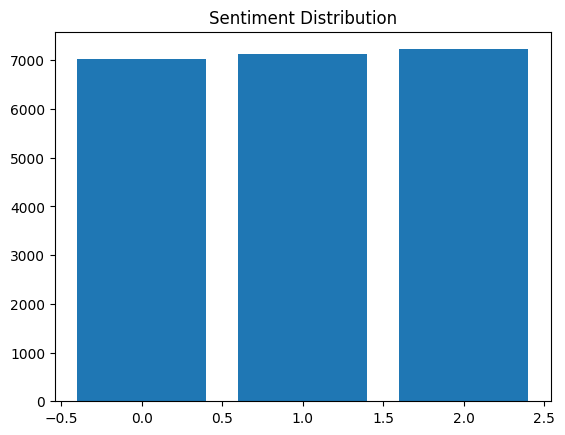

In [ ]:
plot_names = combined_df['sentiment'].value_counts().keys()
plot_values = combined_df['sentiment'].value_counts().values

plt.title('Sentiment Distribution')
plt.bar(plot_names, plot_values)

## **Text Preprocessing**

**References**:
https://www.kaggle.com/code/parulpandey/eda-and-preprocessing-for-bert#4.-Text-Data-Preprocessing

https://aihub.org/2023/03/30/methods-for-addressing-class-imbalance-in-deep-learning-based-natural-language-processing/

The following steps are done in the text-preprocessing steps:

* Lowercasing ✅
* Contractions Removal ✅
* Emoji Removal ✅
* Removing special characters (punctuations, currency signs, digits) ✅
* Stopword Removal and Lemmatization ✅

####**Lowercasing**

In [ ]:
combined_df['Content'] = combined_df['Content'].str.lower()

#### **Creating an nlp object for using spacy**

In [ ]:
nlp = spacy.load("en_core_web_lg")

#### **Applying Cleaning Methods**

#### **Tokenization, Removing Contractions, Emojis, Punctuations, Currencies and Numbers**

In [ ]:
def text_cleaning(text):

  # Removing Contractions
  expanded_text = []
  for word in text.split():
    expanded_text.append(contractions.fix(word))
  expanded_text = ' '.join(expanded_text)
  expanded_text



  # Removing Emojis
  emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
  emoji_removed = re.sub(emoj, '', expanded_text)

  # Removing numbers, currencies and punctuations
  doc = nlp(emoji_removed)
  clean = []
  for token in doc:
    if token.ent_type_ == 'MONEY' or token.is_currency or token.like_num or token.is_punct:
      continue
    clean.append(token.text)
  num_removed = ' '.join(clean)

  return num_removed

#### **Applying another cleaning function, removing square brackets, links and words containing numbers and punctuations if any are left after the first round**

In [ ]:
def clean_text(text):
  '''Removing text in square brackets,remove links,remove punctuation
  and remove words containing numbers.'''
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  return text

In [ ]:
%%time
combined_df['text_clean'] = combined_df['Content'].apply(text_cleaning)

CPU times: user 6min 10s, sys: 886 ms, total: 6min 11s
Wall time: 6min 15s


In [ ]:
combined_df.head()

,Rating,Content,Source,sentiment,text_clean
0,4.0,not sure yet. don't have the item,PowerReviews,2,not sure yet do not have the item
1,4.0,it would be nice if i could finish shopping be...,PowerReviews,2,it would be nice if i could finish shopping be...
2,4.0,"seemless, so far. need to wait for delivery to...",PowerReviews,2,seemless so far need to wait for delivery to g...
3,4.0,website slow.,PowerReviews,2,website slow
4,4.0,easy to use online system,PowerReviews,2,easy to use online system


In [ ]:
%%time
combined_df['cleaned_text'] = combined_df['text_clean'].apply(str).apply(lambda x: clean_text(x))

CPU times: user 1.01 s, sys: 6.61 ms, total: 1.02 s
Wall time: 1.03 s


#### **Raw Content**

In [ ]:
combined_df['Content'][5]

"ordered a used sigma 28-70 for l mount at a great price. had quite a few issues with the website when ordering on my phone so i had to remove the item from my basket and try again on my computer which did panic me a bit as i didn't want someone to swoop in. never ordered from wex before but many friends trust them and they seem to be incredibly well established."

#### **Cleaned Content**

In [ ]:
combined_df['cleaned_text'][5]

'ordered a used sigma for l mount at a great price had quite a few issues with the website when ordering on my phone so i had to remove the item from my basket and try again on my computer which did panic me a bit as i did not want someone to swoop in never ordered from wex before but many friends trust them and they seem to be incredibly well established'

#### **Adding a Word Count column**
This is to calculate the no. of words in every review

In [ ]:
combined_df['word_count'] = combined_df['cleaned_text'].apply(lambda x: len(str(x).split()))

In [ ]:
combined_df.head()

,Rating,Content,Source,sentiment,text_clean,cleaned_text,word_count
0,4.0,not sure yet. don't have the item,PowerReviews,2,not sure yet do not have the item,not sure yet do not have the item,8
1,4.0,it would be nice if i could finish shopping be...,PowerReviews,2,it would be nice if i could finish shopping be...,it would be nice if i could finish shopping be...,14
2,4.0,"seemless, so far. need to wait for delivery to...",PowerReviews,2,seemless so far need to wait for delivery to g...,seemless so far need to wait for delivery to g...,11
3,4.0,website slow.,PowerReviews,2,website slow,website slow,2
4,4.0,easy to use online system,PowerReviews,2,easy to use online system,easy to use online system,5


In [ ]:
combined_df = combined_df.drop(['text_clean'], axis = 1)

In [ ]:
combined_df.head()

,Rating,Content,Source,sentiment,cleaned_text,word_count
0,4.0,not sure yet. don't have the item,PowerReviews,2,not sure yet do not have the item,8
1,4.0,it would be nice if i could finish shopping be...,PowerReviews,2,it would be nice if i could finish shopping be...,14
2,4.0,"seemless, so far. need to wait for delivery to...",PowerReviews,2,seemless so far need to wait for delivery to g...,11
3,4.0,website slow.,PowerReviews,2,website slow,2
4,4.0,easy to use online system,PowerReviews,2,easy to use online system,5


#### **Stopword Removal and Lemmatization**

In [ ]:
def lemmatization(text):
  doc = nlp(text)
  new_string = []

  for word in doc:
    if word.is_stop:
      continue

    new_string.append(word.lemma_)
  return ' '.join(new_string)

In [ ]:
%%time
combined_df['sanitized'] = combined_df['cleaned_text'].apply(lemmatization)

CPU times: user 5min 38s, sys: 822 ms, total: 5min 39s
Wall time: 5min 48s


#### **Text without Stopwords and Lemmatized**

In [ ]:
combined_df['cleaned_text'][10]

'good clear website easy to use'

#### **Text WITH Stopwords and Lemmatized**

In [ ]:
combined_df['sanitized'][10]

'good clear website easy use'

In [ ]:
combined_df.head()

,Rating,Content,Source,sentiment,cleaned_text,word_count,sanitized
0,4.0,not sure yet. don't have the item,PowerReviews,2,not sure yet do not have the item,8,sure item
1,4.0,it would be nice if i could finish shopping be...,PowerReviews,2,it would be nice if i could finish shopping be...,14,nice finish shopping hit
2,4.0,"seemless, so far. need to wait for delivery to...",PowerReviews,2,seemless so far need to wait for delivery to g...,11,seemless far need wait delivery star
3,4.0,website slow.,PowerReviews,2,website slow,2,website slow
4,4.0,easy to use online system,PowerReviews,2,easy to use online system,5,easy use online system


#### **Save Cleaned Combined Dataframe to CSV for future**

In [ ]:
combined_df.to_csv(os.getcwd() + '/CFA_Wex/MyDrive/cleaned_combined_reviews_7000.csv', index=False)

## **Plots**

Reference: https://www.kaggle.com/code/parulpandey/eda-and-preprocessing-for-bert#2.-General-EDA

#### **Sentiment Distribution Plot**

In [ ]:
combined_df['sentiment'].value_counts()

sentiment
2    7227
1    7131
0    7020
Name: count, dtype: int64

In [ ]:
combined_df['sentiment'].value_counts(normalize=True)

sentiment
2    0.338058
1    0.333567
0    0.328375
Name: proportion, dtype: float64

* ~33% of the sentiments are of Positive
* ~33% of the sentiments are of Neutral
* ~33% of the sentiments are of Negative

In [ ]:
fig = px.histogram(combined_df,x="sentiment", color='sentiment', title = 'Sentiment Distribution', labels={'x': 'sentiment', 'y': 'frequency'})
fig.update_layout(bargap=0.2)
fig.show()

#### **Creating Dataframes for Positive, Negative and Neutral Sentiments**

In [ ]:
pos = combined_df[combined_df['sentiment']==2]
neg = combined_df[combined_df['sentiment']==0]
neutral = combined_df[combined_df['sentiment']==1]

#### **Positive Rating Reviews Word count**

In [ ]:
fig = px.histogram(pos,x="word_count", title = 'Positive Rating Word Count', labels={'word_count': 'review length'})
fig.update_layout(bargap=0.2)
fig.show()

#### **Neutral Rating Reviews Word count**

In [ ]:
fig = px.histogram(neutral,x="word_count", title = 'Neutral Rating Word Count', labels={'word_count': 'review length'})
fig.update_layout(bargap=0.2)
fig.show()

#### **Negative Rating Reviews Word count**

In [ ]:
fig = px.histogram(neg,x="word_count", title = 'Negative Rating Word Count', labels={'word_count': 'review length'})
fig.update_layout(bargap=0.2)
fig.show()

#### **Word Frequency Plot**
**Plotting** the most common words in the dataset

In [ ]:
count = 50

In [ ]:
word_count = Counter()
for text in combined_df['sanitized']:
  for word in text.split():
    word_count[word] +=1

freq_list = word_count.most_common(count)

words = []
freq = []
for tuple_item in freq_list:
  words.append(tuple_item[0])
  freq.append(tuple_item[1])
words = np.array(words)
freq = np.array(freq)

fig = px.bar(x= words, y=freq, title = 'Word Frequency', labels ={'x':'Word', 'y':'Frequency'})
fig.show()

#### **Top 50 Words in Positive sentiments**

In [ ]:
word_count = Counter()
for text in pos['sanitized']:
  for word in text.split():
    word_count[word] +=1

freq_list = word_count.most_common(count)

words = []
freq = []
for tuple_item in freq_list:
  words.append(tuple_item[0])
  freq.append(tuple_item[1])
words = np.array(words)
freq = np.array(freq)

fig = px.bar(x= words, y=freq, title = 'Word Frequency', labels ={'x':'Word', 'y':'Frequency'}, color_discrete_sequence =['green'])
fig.show()

#### **Top 50 Words in Neutral sentiments**

In [ ]:
word_count = Counter()
for text in neutral['sanitized']:
  for word in text.split():
    word_count[word] +=1

freq_list = word_count.most_common(count)

words = []
freq = []
for tuple_item in freq_list:
  words.append(tuple_item[0])
  freq.append(tuple_item[1])
words = np.array(words)
freq = np.array(freq)

fig = px.bar(x= words, y=freq, title = 'Word Frequency', labels ={'x':'Word', 'y':'Frequency'}, color_discrete_sequence =['orange'])
fig.show()

#### **Top 50 Words in Negative sentiments**

In [ ]:
word_count = Counter()
for text in neg['sanitized']:
  for word in text.split():
    word_count[word] +=1

freq_list = word_count.most_common(count)

words = []
freq = []
for tuple_item in freq_list:
  words.append(tuple_item[0])
  freq.append(tuple_item[1])
words = np.array(words)
freq = np.array(freq)

fig = px.bar(x= words, y=freq, title = 'Word Frequency', labels ={'x':'Word', 'y':'Frequency'}, color_discrete_sequence =['orangered'])
fig.show()

#### **Box Plotting Sentiments**

In [ ]:
fig = px.box(combined_df,x="sentiment", y = 'word_count', title = 'Box plot for Sentiments',points="all", color='sentiment', labels={'word_count':'frequency'})
fig.show()

#### **Wordcloud**

In [ ]:
from wordcloud import WordCloud, STOPWORDS

In [ ]:
comment_words = ''
stopwords = set(STOPWORDS)
# iterate through the csv file
for val in combined_df['cleaned_text']:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

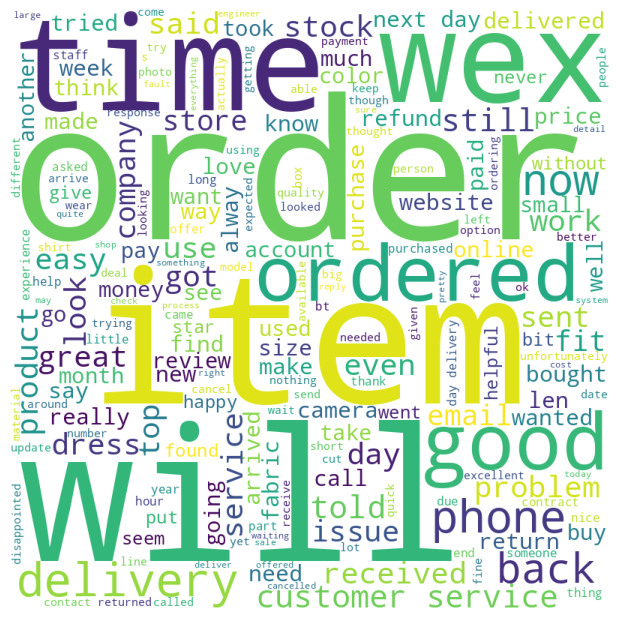

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

## **Model Building**

**References**:
https://www.kaggle.com/code/abhishek/approaching-almost-any-nlp-problem-on-kaggle

#### **Read saved Combined Dataframe to avoid running previous code all over again to save time**

In [ ]:
combined_df = pd.read_csv(path + '/cleaned_combined_reviews_7000.csv')

In [ ]:
combined_df['Rating'].value_counts()

Rating
3.0    7131
4.0    3628
1.0    3607
5.0    3599
2.0    3413
Name: count, dtype: int64

#### **Tain, Test and Val Split**

In [ ]:
X = combined_df.sanitized.values.astype('U')
y = combined_df.sentiment

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(17102,)
(4276,)


In [ ]:
y_train.value_counts(), y_test.value_counts()

(sentiment
 2    5781
 1    5705
 0    5616
 Name: count, dtype: int64,
 sentiment
 2    1446
 1    1426
 0    1404
 Name: count, dtype: int64)

#### **ML Pipelines**: https://www.freecodecamp.org/news/machine-learning-pipeline/

##### **Pipeline for Model Building**

In [ ]:
models = [LogisticRegression(random_state=1),
          RandomForestClassifier(random_state=1),
          KNeighborsClassifier(n_neighbors = 5),
          SVC(random_state=1),
          MultinomialNB()]
results = []
f1scores = []

In [ ]:
%%time
for model in models:
  pipeline = Pipeline([
    ('vectorizer_tri_grams', TfidfVectorizer()),
    ('model', model)])
  pipeline.fit(X_train, y_train)
  scores = pipeline.score(X_test, y_test)
  predicted_val = pipeline.predict(X_test)
  f1_scores = f1_score(y_test, predicted_val, average='macro')
  results.append(scores)
  f1scores.append(f1_scores)

CPU times: user 3min 57s, sys: 3.92 s, total: 4min 1s
Wall time: 4min 5s


In [ ]:
for model, accuracy, f1 in zip(models, results, f1scores):
  print(f"Model: {model} >> Accuracy: {round(np.mean(accuracy), 3)}   |  F1 Score: {round(np.mean(f1), 3)}")

Model: LogisticRegression(random_state=1) >> Accuracy: 0.698   |  F1 Score: 0.696
Model: RandomForestClassifier(random_state=1) >> Accuracy: 0.686   |  F1 Score: 0.683
Model: KNeighborsClassifier() >> Accuracy: 0.473   |  F1 Score: 0.43
Model: SVC(random_state=1) >> Accuracy: 0.709   |  F1 Score: 0.708
Model: MultinomialNB() >> Accuracy: 0.689   |  F1 Score: 0.683


#### **Using the models with best accuracies and F1 scores**

* Logistic Regression
* SVC
* Random Forest

#### **Hyperparameter Tuning**
**Using GridSearchCV for Hyperparameter Tuning for the Baseline ML models**

In [ ]:
param_grid_lr = {
    'model__penalty': ['l1', 'l2'],
    'model__C': [0.1, 1, 10],
    'model__solver': ['liblinear'],
    'model__max_iter': [100]
}

param_grid_rf = {
    'model__criterion': ['gini'],
    'model__min_samples_split': [4]
}

param_grid_svc = {
    'model__C': [1, 10],
    'model__gamma': [0.01, 0.001],
    'model__kernel': ['rbf']
}

In [ ]:
param_grid = [param_grid_lr, param_grid_rf, param_grid_svc]
models_final = [LogisticRegression(random_state=1),
          RandomForestClassifier(random_state=1),
          SVC(random_state=1)]

In [ ]:
%%time

best_params = []
best_estimator = []

for model, grid_params in zip(models_final, param_grid):
  print(f"Model: {model}")
  clf_pipeline = Pipeline(steps =[('vectorizer_tri_grams', TfidfVectorizer()),('model', model)])
  gs= GridSearchCV(clf_pipeline, grid_params, cv=5, scoring='accuracy', refit=True,verbose=3)
  gs.fit(X_train, y_train)
  best_params.append(gs.best_params_)
  best_estimator.append(gs.best_estimator_)

Model: LogisticRegression(random_state=1)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END model__C=0.1, model__max_iter=100, model__penalty=l1, model__solver=liblinear;, score=0.664 total time=   1.3s
[CV 2/5] END model__C=0.1, model__max_iter=100, model__penalty=l1, model__solver=liblinear;, score=0.659 total time=   1.4s
[CV 3/5] END model__C=0.1, model__max_iter=100, model__penalty=l1, model__solver=liblinear;, score=0.667 total time=   1.4s
[CV 4/5] END model__C=0.1, model__max_iter=100, model__penalty=l1, model__solver=liblinear;, score=0.661 total time=   1.2s
[CV 5/5] END model__C=0.1, model__max_iter=100, model__penalty=l1, model__solver=liblinear;, score=0.664 total time=   0.8s
[CV 1/5] END model__C=0.1, model__max_iter=100, model__penalty=l2, model__solver=liblinear;, score=0.697 total time=   0.9s
[CV 2/5] END model__C=0.1, model__max_iter=100, model__penalty=l2, model__solver=liblinear;, score=0.695 total time=   0.9s
[CV 3/5] END model__C=0.1, mod

#### **Best Hyper Parameters**

In [ ]:
abrv = ['lr','rf','svc']
for a, p, e in zip(abrv,best_params,best_estimator):
    print(f"""Model : {a.upper()}
                        Best Parameter : {p}
                        Best Estimator : {e} \n""")

Model : LR
                        Best Parameter : {'model__C': 1, 'model__max_iter': 100, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
                        Best Estimator : Pipeline(steps=[('vectorizer_tri_grams', TfidfVectorizer()),
                ('model',
                 LogisticRegression(C=1, random_state=1, solver='liblinear'))]) 

Model : RF
                        Best Parameter : {'model__criterion': 'gini', 'model__min_samples_split': 4}
                        Best Estimator : Pipeline(steps=[('vectorizer_tri_grams', TfidfVectorizer()),
                ('model',
                 RandomForestClassifier(min_samples_split=4, random_state=1))]) 

Model : SVC
                        Best Parameter : {'model__C': 10, 'model__gamma': 0.01, 'model__kernel': 'rbf'}
                        Best Estimator : Pipeline(steps=[('vectorizer_tri_grams', TfidfVectorizer()),
                ('model', SVC(C=10, gamma=0.01, random_state=1))]) 



#### **Models with Hyper Tuned Parameters**

In [ ]:
models_hyp = [LogisticRegression(C=1, penalty='l2', max_iter=100, solver='liblinear'),
          RandomForestClassifier(criterion='gini', min_samples_split=4,random_state=1),
          SVC(C=10, gamma=0.01, kernel= 'rbf', random_state=1)]

models_hyp_names = ['Logistic Regression', 'RandomForest Classifier', 'SVC']
results_hyper = []
f1scores_hyper = []
model_stored = []

In [ ]:
%%time
for model in models_hyp:
  pipeline = Pipeline([
    ('vectorizer_tri_grams', TfidfVectorizer()),
    ('model', model)])
  pipeline.fit(X_train, y_train)
  scores = pipeline.score(X_test, y_test)
  predicted_val = pipeline.predict(X_test)
  f1_scores = f1_score(y_test, predicted_val, average='macro')
  results_hyper.append(scores)
  f1scores_hyper.append(f1_scores)

CPU times: user 2min 6s, sys: 1 s, total: 2min 7s
Wall time: 2min 8s


In [ ]:
for model, accuracy, f1 in zip(models_hyp_names, results_hyper, f1scores_hyper):
    print(f"""Model: {model}
                                Accuracy: {round(np.mean(accuracy), 4)}
                                F1 Score: {round(np.mean(f1), 4)}\n""")

Model: Logistic Regression
                                Accuracy: 0.6988
                                F1 Score: 0.6964

Model: RandomForest Classifier
                                Accuracy: 0.6822
                                F1 Score: 0.6787

Model: SVC
                                Accuracy: 0.6983
                                F1 Score: 0.6983



In [ ]:
f1scores = [f1scores[0], f1scores[1], f1scores[4]]

In [ ]:
results = [results[0], results[1], results[4]]

#### **Results**
**Models Comparison**

In [ ]:
#Creating list to store F1 scores with hyperparameters
df_plot = pd.DataFrame( {"Models": ["Logistic Regression",
                   "Random Forest",
                   "SVC"]*2,
          "F1 Scores": f1scores + f1scores_hyper,
          "Accuracy": results + results_hyper,
          "Normal/Hyper":(["Normal"]*3+["Hypertuned"]*3)
         })
df_plot

,Models,F1 Scores,Accuracy,Normal/Hyper
0,Logistic Regression,0.696196,0.697848,Normal
1,Random Forest,0.682502,0.686155,Normal
2,SVC,0.682756,0.689429,Normal
3,Logistic Regression,0.696355,0.698784,Hypertuned
4,Random Forest,0.678670,0.682180,Hypertuned
5,SVC,0.698329,0.698316,Hypertuned


Accuracy of SVC and Logistic Regression improved after hyperparameter tuning!

##### **SVC**

In [ ]:
%%time
svc = SVC(C=10, gamma=0.01, kernel= 'rbf', random_state=1)

model_svc = Pipeline([
    ('vectorizer_tri_grams', TfidfVectorizer()),
    ('model', svc)])

model_svc.fit(X_train, y_train)
predict_svc = model_svc.predict(X_test)
score = model_svc.score(X_test, y_test)
print(score)

0.6983161833489242
CPU times: user 1min 29s, sys: 587 ms, total: 1min 30s
Wall time: 1min 32s


##### **Evaluation / Confusion Matrix**

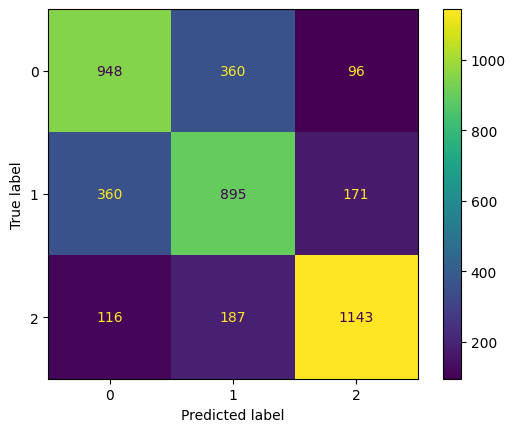

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, predict_svc)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

In [ ]:
print(classification_report(y_test, predict_svc, labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.67      0.68      0.67      1404
           1       0.62      0.63      0.62      1426
           2       0.81      0.79      0.80      1446

    accuracy                           0.70      4276
   macro avg       0.70      0.70      0.70      4276
weighted avg       0.70      0.70      0.70      4276



##### **Logistic Regression**

In [ ]:
%%time
logistic_regression = LogisticRegression(C=1, penalty='l2', max_iter=100, solver='liblinear')

model_lr = Pipeline([
    ('vectorizer_tri_grams', TfidfVectorizer()),
    ('model', logistic_regression)])

model_lr.fit(X_train, y_train)
predict_lr = model_lr.predict(X_test)
score = model_lr.score(X_test, y_test)
print(score)

0.6987839101964453
CPU times: user 2.14 s, sys: 532 ms, total: 2.67 s
Wall time: 4.68 s


##### **Evaluation / Confusion Matrix**

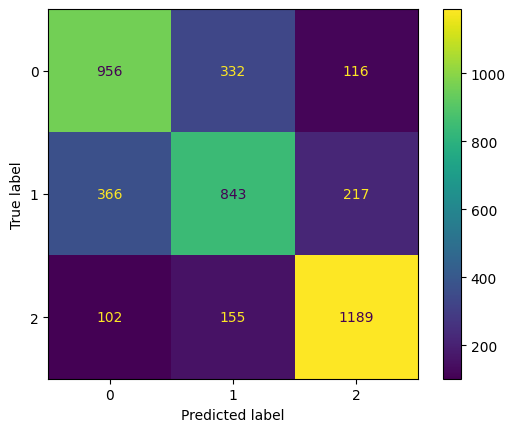

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, predict_lr)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

In [ ]:
print(classification_report(y_test, predict_lr, labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.67      0.68      0.68      1404
           1       0.63      0.59      0.61      1426
           2       0.78      0.82      0.80      1446

    accuracy                           0.70      4276
   macro avg       0.70      0.70      0.70      4276
weighted avg       0.70      0.70      0.70      4276



#### **Saving SVC Model**

In [ ]:
import pickle

filename = path + '/model_svc_approach2.sav'
pickle.dump(model_svc, open(filename, 'wb'))

#### **Saving Logistic Regression Model**

In [ ]:
filename = path + '/model_lr_approach2.sav'
pickle.dump(model_lr, open(filename, 'wb'))

## **Adding Predictions to the Dataset**

### **Applying Cleaning Methods**

In [ ]:
df = pd.read_csv(path + '/combined_reviews.csv')

In [ ]:
df.head()

,Rating,Content,Company,sentiment
0,1,Took too long to arrive. When I had to reautho...,Trust Pilot,0
1,1,Zero packaging. Bought an expensive scanner. T...,Trust Pilot,0
2,1,Ordered a product only to be told in an automa...,Trust Pilot,0
3,1,"Brought used speedlight, unfortunately it arri...",Trust Pilot,0
4,1,Really bad experience till now already paid fo...,Trust Pilot,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79935 entries, 0 to 79934
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Rating     79935 non-null  int64 
 1   Content    79935 non-null  object
 2   Company    79935 non-null  object
 3   sentiment  79935 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.4+ MB


In [ ]:
df = df.drop_duplicates(subset=['Content'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27596 entries, 0 to 53727
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Rating     27596 non-null  int64 
 1   Content    27596 non-null  object
 2   Company    27596 non-null  object
 3   sentiment  27596 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.1+ MB


In [ ]:
print(df['Rating'].value_counts())

Rating
5    12733
4     9552
3     2505
1     1735
2     1071
Name: count, dtype: int64


In [ ]:
%%time
df['text_clean'] = df['Content'].apply(text_cleaning)

CPU times: user 4min 29s, sys: 756 ms, total: 4min 30s
Wall time: 5min 4s


In [ ]:
df['cleaned_text'] = df['text_clean'].apply(str).apply(lambda x: clean_text(x))

In [ ]:
%%time
df['sanitized'] = df['cleaned_text'].apply(lemmatization)

CPU times: user 3min 56s, sys: 688 ms, total: 3min 56s
Wall time: 4min 7s


### **Loading SVC Model**

In [ ]:
import pickle

# Load the model from the file
filename = path + '/model_svc_approach2.sav'
model_svc = pickle.load(open(filename, 'rb'))

### **Getting SVC Model Predictions**

In [ ]:
%%time
X = df.sanitized.values.astype('U')
predictions = model_svc.predict(X)

CPU times: user 46.2 s, sys: 240 ms, total: 46.5 s
Wall time: 50.5 s


In [ ]:
df['predictions'] = predictions

In [ ]:
final_df = df.drop(['text_clean', 'cleaned_text','sanitized'], axis = 1)

In [ ]:
final_df.head()

,Rating,Content,Company,sentiment,predictions
0,1,Took too long to arrive. When I had to reautho...,Trust Pilot,0,1
1,1,Zero packaging. Bought an expensive scanner. T...,Trust Pilot,0,0
2,1,Ordered a product only to be told in an automa...,Trust Pilot,0,1
3,1,"Brought used speedlight, unfortunately it arri...",Trust Pilot,0,2
4,1,Really bad experience till now already paid fo...,Trust Pilot,0,0


In [ ]:
final_df['sentiment'].value_counts()

sentiment
2    22285
0     2806
1     2505
Name: count, dtype: int64

In [ ]:
final_df['predictions'].value_counts()

predictions
2    18853
1     4783
0     3960
Name: count, dtype: int64

### **True vs Predicted Labels**

In [ ]:
names_sent = df['sentiment'].value_counts().keys()
values_sent = df['sentiment'].value_counts().values

In [ ]:
names_pred = df['predictions'].value_counts().keys()
values_pred = df['predictions'].value_counts().values

In [ ]:
# Create the plot
fig = go.Figure(data=[
    go.Bar(
        name='True Labels',
        x=names_sent,
        y=values_sent,
        text=values_sent,
        textposition='auto'
    ),
    go.Bar(
        name='Predicted Labels',
        x=names_pred,
        y=values_pred,
        text=values_pred,
        textposition='auto'
    )
])

# Customize layout
fig.update_layout(
    title='True vs Predicted Labels',
    xaxis_title='Labels',
    yaxis_title='Values',
    barmode='group'
)

fig.show()